In [ ]:
import numpy as np
import pandas as pd 
import glob

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm


def setup_mpl():
    """
    Easy setup for matplotlib
    """
    # Change plot
    mpl.rcParams['font.size'] = 16
    # Remove top and right axes
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False
    # No borders in the legend
    mpl.rcParams['legend.frameon'] = False
setup_mpl()

# Define colors
niceblue = "#005b96"
nicered = "#f15152"
nicegreen = "#09814a"
lightblue = "#b3cde0"

# DATA FOLDER
DATA_FOLDER = "./data/"

In [ ]:
"""
    Load data on villages
"""

# Household info
info = pd.read_csv(DATA_FOLDER + "hh-info.csv")
# Leaders-adopters
leadapt = pd.read_csv(DATA_FOLDER + "leaders-adopters.csv")
# Transform villages numbers to make everything coherent
nmap = dict(zip(sorted(leadapt.village.unique()), np.arange(leadapt.village.nunique())))
leadapt["village"] = leadapt.village.map(nmap)
# get two dictionaries
leaders = leadapt.set_index(["village", "hh"]).to_dict()["leader"]
adopters = leadapt.set_index(["village", "hh"]).to_dict()["adopter"]
# Get array mask
leaders_mask = dict()
mask = dict()
for village in sorted(leadapt.village.unique()):
    leaders_mask[village] = leadapt.loc[leadapt.village == village].leader.values
    mask[village] = leadapt.loc[leadapt.village == village].adopter.values
# Adjacency_matrix
adjmats = dict()
 
for file in sorted(glob.glob(DATA_FOLDER + "adjmat*.csv")):
    # find key adjmat 1 -> 0
    key = int(file.split("/")[-1].split(".")[0].strip("adjmat")) -1
    # load data as numpy array
    village_adj = np.loadtxt(file, delimiter=",")
    adjmats[key] = village_adj

graphs = dict()
for key, value in adjmats.items():
    village_graph = nx.from_numpy_array(value)
    graphs[key] = village_graph


In [ ]:
# Has everything worked? Plot a graph as an example.

fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

# Compute nodes positions using spring layout
pos = nx.kamada_kawai_layout(graphs[0])

# Draw the graph nodes
nx.draw_networkx_nodes(
    graphs[0],
    pos,
    node_size=(adjmats[0].sum(axis=0)*100)**0.7,
    node_color=niceblue,
    edgecolors=lightblue,
    linewidths=1,
    ax=ax
)

# Draw the graph edges.
nx.draw_networkx_edges(
    graphs[0],
    pos,
    edge_color="gray",
    width=1,
    alpha=0.5,
    ax=ax
)

# remove axis
ax.axis("off")

plt.show()


In [ ]:
# A few basic statistics of our networks: number of nodes, number of edges, average degree, density, and number of components.
n_nodes = np.zeros(len(graphs))
n_edges = np.zeros(len(graphs))
avg_degree = np.zeros(len(graphs))
density = np.zeros(len(graphs))
diameter = np.zeros(len(graphs))

for i, graph in graphs.items():
    n_nodes[i] = graph.number_of_nodes()
    n_edges[i] = graph.number_of_edges()
    avg_degree[i] = np.mean([d[1] for d in graph.degree()])
    density[i] = nx.density(graph)
    n_components = nx.number_connected_components(graph)

# Plot distribution of number of nodes
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(n_nodes, bins=10, color=niceblue, edgecolor="white")
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Frequency")
plt.show()

# Plot distribution of density
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(density, bins=10, color=niceblue, edgecolor="white")
ax.set_xlabel("Density")
ax.set_ylabel("Frequency")
plt.show()

In [ ]:
"""
    BSS, the microfinance institution mentioned in the paper, targeted "leaders" in the villages, assuming that they have a central role in the social network.
    Let's see if this is true.
"""

# Compute degree centrality of leaders in each graph
avg_dc_leaders = np.zeros(len(graphs))
avg_dc_nonleaders = np.zeros(len(graphs))
# Compute betweenness centrality of leaders in each graph
avg_bc_leaders = np.zeros(len(graphs))
avg_bc_nonleaders = np.zeros(len(graphs))
# Compute closeness centrality of leaders in each graph
avg_cc_leaders = np.zeros(len(graphs))
avg_cc_nonleaders = np.zeros(len(graphs))

for i, graph in graphs.items():

    degree_centrality = np.array(list(nx.degree_centrality(graph).values()))
    degree_centrality = degree_centrality / degree_centrality.max()
    avg_dc_leaders[i] = degree_centrality[leaders_mask[i]].mean()
    avg_dc_nonleaders[i] = degree_centrality[~leaders_mask[i]].mean()
    
    betweenness_centrality = np.array(list(nx.betweenness_centrality(graph).values()))
    betweenness_centrality = betweenness_centrality / betweenness_centrality.max()
    avg_bc_leaders[i] = betweenness_centrality[leaders_mask[i]].mean()
    avg_bc_nonleaders[i] = betweenness_centrality[~leaders_mask[i]].mean()

    closeness_centrality = np.array(list(nx.closeness_centrality(graph).values()))
    closeness_centrality = closeness_centrality / closeness_centrality.max()
    avg_cc_leaders[i] = closeness_centrality[leaders_mask[i]].mean()
    avg_cc_nonleaders[i] = closeness_centrality[~leaders_mask[i]].mean()

In [ ]:
"""
    Plot results
"""
# Make scatterplot of leaders vs non-leaders centrality
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter plot of degree centrality; blue circles
ax.scatter(
    avg_dc_leaders,
    avg_dc_nonleaders,
    color=niceblue,
    s=100,
    marker="o",
    facecolor="white",
    linewidths=2,
    label="Degree centrality",
)
# Scatter plot of betweenness centrality; red squares
ax.scatter(
    avg_bc_leaders,
    avg_bc_nonleaders,
    color=nicered,
    s=100,
    marker="s",
    facecolor="white",
    linewidths=2,
    label="Betweenness centrality",
)
# Scatter plot of closeness centrality; green triangles
ax.scatter(
    avg_cc_leaders,
    avg_cc_nonleaders,
    color=nicegreen,
    s=100,
    marker="^",
    facecolor="white",
    linewidths=2,
    label="Closeness centrality",
)

# Plot diagonal line
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

# Add legend
ax.legend(loc="upper left", fontsize=20)

# Add labels
ax.set_xlabel("Average centrality of leaders", fontsize=20)
ax.set_ylabel("Average centrality of non-leaders", fontsize=20)

plt.show()

In [144]:
"""
    Assortative/disassortative mixing: due adopters connect more with non-adopters?
"""
def compute_assortativity(M):
    return (np.trace(M) - np.sum(2*M[0, 1]**2)) / (1 - np.sum(2*M[0,j1**2))

In [145]:
assortativity = np.zeros(len(graphs))

for i, graph in graphs.items():
    # Select mask
    mask = adopters_mask[i].astype(bool)
    # Get density of connections within adopters
    matrix_index = np.ix_(mask, mask)
    density_adopters = adjmats[i][matrix_index].sum() / adjmats[i].sum()
    # Get density of connections within non-adopters
    matrix_index = np.ix_(~mask, ~mask)
    density_nonadopters = adjmats[i][matrix_index].sum() / adjmats[i].sum()
    # Get density of connections between adopters and non-adopters
    matrix_index = np.ix_(mask, ~mask)
    density_adopters_nonadopters = adjmats[i][matrix_index].sum() / adjmats[i].sum()
    # Compute assortativity
    M = np.zeros((2, 2))
    M[0, 0] = density_adopters
    M[0, 1] = density_adopters_nonadopters
    M[1, 0] = density_adopters_nonadopters
    M[1, 1] = density_nonadopters

    assortativity[i] = compute_assortativity(M)

IndexError: index 9 is out of bounds for axis 0 with size 2

In [146]:
# Now let's compute some random benchmarks!
n_iter = 100
assortativity_random = np.zeros((len(graphs), n_iter))
for i, graph in graphs.items():
    # Get adopters mask
    mask = adopters_mask[i].astype(bool)
    # Generate random graphs
    for j in tqdm(range(n_iter), desc="Graph {}".format(i)):
        flag = False
        degree_sequence = adjmats[i].sum(axis=1).astype(int)
        # Check that there are no self loops or multiedges; if so, try again
       
        # Randomize the graph with the configuration model
        graph_random = nx.configuration_model(adjmats[i].sum(axis=1).astype(int))
        # Turn to undirected graph
        graph_random = nx.Graph(graph_random)
        # Remove self loops
        graph_random.remove_edges_from(nx.selfloop_edges(graph_random))
        adj_random = nx.adjacency_matrix(graph_random)
        # Get density of connections within adopters
        matrix_index = np.ix_(mask, mask)
        density_adopters = adj_random[matrix_index].sum() / adj_random.sum()
        # Get density of connections within non-adopters
        matrix_index = np.ix_(~mask, ~mask)
        density_nonadopters = adj_random[matrix_index].sum() / adj_random.sum()
        # Get density of connections between adopters and non-adopters
        matrix_index = np.ix_(mask, ~mask)
        density_adopters_nonadopters = adj_random[matrix_index].sum() / adj_random.sum()
        # Compute assortativity
        M = np.zeros((2, 2))
        M[0, 0] = density_adopters
        M[0, 1] = density_adopters_nonadopters
        M[1, 0] = density_adopters_nonadopters
        M[1, 1] = density_nonadopters

        assortativity_random[i, j] = compute_assortativity(M)
        

Graph 0:   2%|▏         | 2/100 [00:00<00:02, 45.06it/s]


IndexError: index 2 is out of bounds for axis 1 with size 2

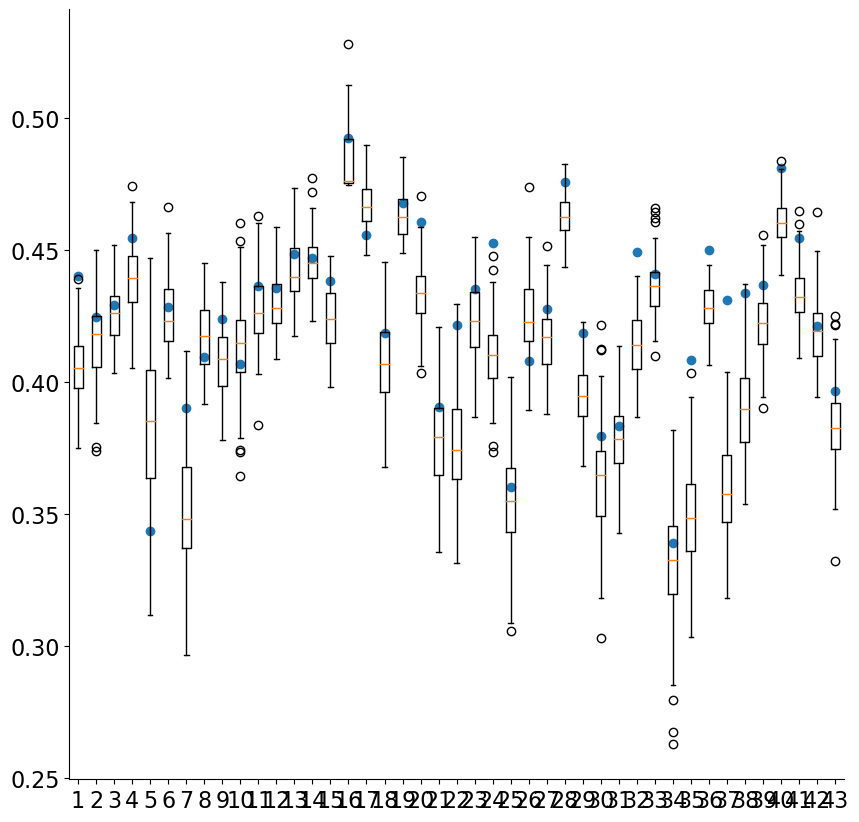

In [140]:
# Plot results

fig, ax = plt.subplots(figsize=(10, 10))
# boxplot plot for the benchmarks
bp = ax.boxplot(
    assortativity_random.T,
)
# Scatter plot of assortativity
ax.scatter(
    np.arange(len(graphs)) + 1,
    assortativity,
)
plt.show()



